<a href="https://colab.research.google.com/github/Sirabhop/Preclinical-AD-EEG-classification/blob/master/Machine_Learning_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [104]:
from google.colab import drive
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [34]:
#Set working directory and import cookbook
os.chdir("/content/drive/My Drive/Colab Notebooks/")

#Download eeg feature extraction function
%run EEG_Feature_Extraction.ipynb

19.25


# **Import Data**

In [0]:
#Compute EEG feature
os.chdir("/content/drive/My Drive/EEG Data")
subjectID = ['SS2', 'SS4', 'SS5', 'SS6', 'SS7', 'SS8']
EEG_feature = extract_feature(subjectID)

In [0]:
EEG_feature.to_csv('/content/drive/My Drive/My Project/Senior Project-Dementia/Results/RESEARCH DATA/EEG_features.csv')

In [0]:
#Import FCSRT
FCSRT = pd.read_csv("FCSRT.csv")
FCSRT_o = FCSRT.iloc[[2, 3,4,5,6,7], 1:]
FCSRT_o.reset_index(drop = True, inplace = True)

#Import MoCA
MoCA = pd.read_csv("MoCA.csv", usecols = ['SUM'])
MoCA.rename({'SUM':'MoCA'}, inplace = True, axis = 1)
MoCA_o = MoCA.iloc[[1,3,4,5,6,7]]
MoCA_o.reset_index(drop = True, inplace = True)

#Import EEG
EEG = pd.read_csv("EEG_features.csv")

#Create group
Group = pd.DataFrame(data = {'group':(1,0,1,1,0,0)})

#Combined data
df_original = pd.concat([Group, EEG_feature, FCSRT_o , MoCA_o] , axis = 1)
df_original['group'] = df_original['group'].astype('category')

Get data summary

In [0]:
def mean_confidence_interval(data, confidence=0.95):
  import numpy as np
  import scipy.stats  


  a = 1.0 * np.array(data)
  n = len(a)
  m, se = np.mean(a), scipy.stats.sem(a)
  h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
  return m-h, m+h

In [0]:
df = df_original.drop(['id','group'], axis = 1)
ci = pd.DataFrame(columns=['lower', 'upper'])
for x in range(len(df.columns)):
  ci.loc[x] = mean_confidence_interval(df.iloc[:,x])
describe = df.describe.transpose()

In [0]:
describe['lower'] = ci['lower'].values
describe['upper'] = ci['upper'].values

#Export
describe.to_csv('/content/drive/My Drive/My Project/Senior Project-Dementia/Results/RESEARCH DATA/descriptive.csv')

# **Data Preprocessing**

#### **1) Scaling**

In [0]:
from sklearn import preprocessing

In [0]:
#Min-Max Scaling
df_original.drop('id', axis = 1, inplace = True)

scaler = preprocessing.MinMaxScaler()
df_original[df_original.columns] = scaler.fit_transform(df_original[df_original.columns])

df = df_original

#### **2) Generate Data**

The section below, I've random the value of each feature in order to demonstrate ML model because the situation of *COVID-19* that I cannot continue run the experiment as expected.

In [0]:
from random import random

In [0]:
df_random = pd.DataFrame(columns = df_original.columns)
for x in df_original.columns:
  if x != 'Group':
    df_random[x] = np.random.rand(52)
  else:
    df_random[x] = np.random.randint(0,2,52)

In [0]:
df = df_original.append(df_random, ignore_index = True)
df.tail()

,PSD_Delta,PSD_Theta,PSD_Alpha,PSD_Beta,PSD_Gamma,MSF,SE,AC,wSMI_Alpha,wSMI_Theta,IR-FreeR,IR-CuedR,DL-FreeR,DL-CuedR,MoCA,Group
55,0.807347,0.682497,0.021335,0.035987,0.381992,0.613762,0.052280,0.761692,0.513952,0.476199,0.738040,0.801613,0.066879,0.781259,0.816615,1.0
56,0.485057,0.448023,0.680089,0.031775,0.806532,0.069834,0.892653,0.272981,0.944839,0.461204,0.818933,0.112397,0.796346,0.753916,0.835964,1.0
57,0.536503,0.559438,0.170453,0.626516,0.196223,0.133042,0.470600,0.638751,0.223161,0.278665,0.705056,0.525164,0.885811,0.852113,0.109725,0.0
58,0.412441,0.072450,0.633993,0.221719,0.172257,0.631629,0.164460,0.365358,0.194858,0.917188,0.279845,0.127879,0.354827,0.744854,0.989097,0.0
59,0.379127,0.065893,0.528430,0.187522,0.183076,0.255245,0.006866,0.976507,0.282368,0.193345,0.986599,0.661297,0.992456,0.637758,0.974005,1.0


#### **3) Feature Selection**
using filter method

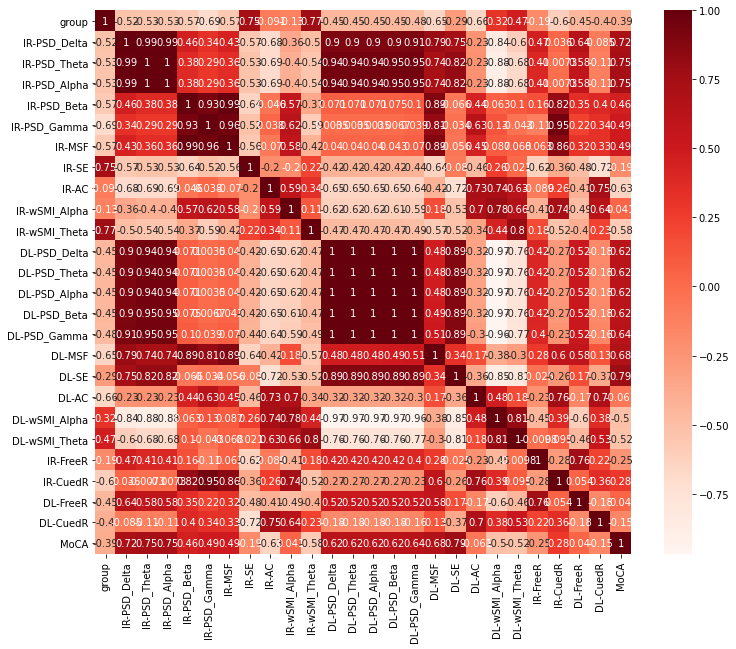

<Figure size 432x288 with 0 Axes>

In [105]:
plt.figure(figsize=(12,10))
cor = df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()
plt.savefig('/content/drive/My Drive/My Project/Senior Project-Dementia/Results/Graphs/heatmap.png')

In [106]:
#Correlation with output variable
cor_target = abs(cor["group"])

#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.5]
relevant_features

group            1.000000
IR-PSD_Delta     0.521704
IR-PSD_Theta     0.534890
IR-PSD_Alpha     0.534890
IR-PSD_Beta      0.571819
IR-PSD_Gamma     0.694848
IR-MSF           0.566841
IR-SE            0.753698
IR-wSMI_Theta    0.772914
DL-MSF           0.648706
DL-AC            0.659458
IR-CuedR         0.603023
Name: group, dtype: float64

In [0]:
selected_features = pd.DataFrame(relevant_features)
selected_features.reset_index(inplace = True)
selected_features.drop([0], inplace = True)

In [108]:
array_selected = selected_features['index'].to_numpy()
array_selected

array(['IR-PSD_Delta', 'IR-PSD_Theta', 'IR-PSD_Alpha', 'IR-PSD_Beta',
       'IR-PSD_Gamma', 'IR-MSF', 'IR-SE', 'IR-wSMI_Theta', 'DL-MSF',
       'DL-AC', 'IR-CuedR'], dtype=object)

# **Model Experimentation**

####**1) Seperate dataframe**


1.   Only EEG & MoCA data
2.   FCSRT & MoCA data
3. All data


In [0]:
#1
X_1 = df[array_selected]
#2
X_2 = df[['IR-FreeR', 'IR-CuedR','DL-FreeR', 'DL-CuedR']]
#3
X_3 = df[['IR-PSD_Delta', 'IR-PSD_Theta', 'IR-PSD_Alpha', 'IR-PSD_Beta',
       'IR-PSD_Gamma', 'IR-MSF', 'IR-SE', 'IR-wSMI_Theta', 'DL-MSF',
       'DL-AC', 'IR-FreeR','DL-FreeR', 'DL-CuedR']]

y = df['group']

####**2) Seperate *Training Set* and *Test Set***

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
#X_1
X_1_train, X_1_test, Y_1_train,Y_1_test = train_test_split(X_1, y, test_size = 0.25, random_state = 0)

#X_2
X_2_train, X_2_test, Y_2_train, Y_2_test = train_test_split(X_2, y, test_size = 0.25, random_state = 0)

#X_3
X_3_train, X_3_test, Y_3_train, Y_3_test = train_test_split(X_3, y, test_size = 0.25, random_state = 0)

####**3) Model Building**

In [0]:
from sklearn.svm import SVC

In [0]:
classifier_1 = SVC(kernel = 'rbf', random_state = 0)
classifier_1.fit(X_1_train, Y_1_train)
Y_1_pred = classifier_1.predict(X_1_test)

classifier_2 = SVC(kernel = 'rbf', random_state = 0)
classifier_2.fit(X_2_train, Y_2_train)
Y_2_pred = classifier_2.predict(X_2_test)

classifier_3 = SVC(kernel = 'rbf', random_state = 0)
classifier_3.fit(X_3_train, Y_3_train)
Y_3_pred = classifier_3.predict(X_3_test)

####**4) Model Evaluation**

In [0]:
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, classification_report

In [0]:
def con_mat_picture(y_test, y_pred, title):
  title = title
  cm = confusion_matrix(y_test, y_pred)
  plt.imshow(cm, cmap=plt.cm.Greens)
  plt.xlabel("Predicted labels")
  plt.ylabel("True labels")

  plt.xticks([], []+ labels)
  plt.yticks([], []+ labels)
  plt.title(title)
  plt.colorbar()
  return plt.show()

In [0]:
def con_mat_picture(y_test, y_pred, title):
  cm = confusion_matrix(y_test, y_pred)
  title = title
  labels = ['Normal', 'Risk']

  fig = plt.figure()
  ax = fig.add_subplot(111)
  cax = ax.matshow(cm)
  plt.title(title)
  fig.colorbar(cax)
  ax.set_xticklabels([''] + labels)
  ax.set_yticklabels([''] + labels)
  plt.xlabel('Predicted')
  plt.ylabel('True')
  return plt.show()

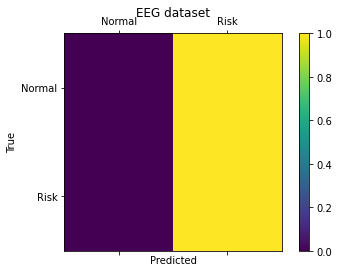

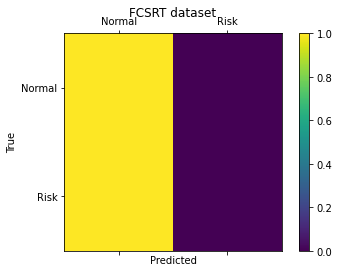

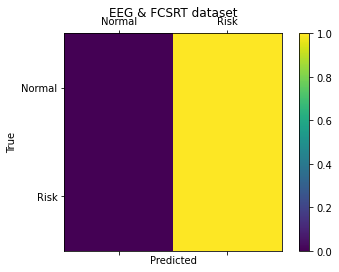

In [120]:
cm_1 = con_mat_picture(Y_1_test, Y_1_pred, 'EEG dataset')
cm_2 = con_mat_picture(Y_2_test, Y_2_pred, 'FCSRT dataset')
cm_3 = con_mat_picture(Y_3_test, Y_3_pred, 'EEG & FCSRT dataset')

In [121]:
print(classification_report(Y_1_test, Y_1_pred))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         1
         1.0       0.50      1.00      0.67         1

    accuracy                           0.50         2
   macro avg       0.25      0.50      0.33         2
weighted avg       0.25      0.50      0.33         2



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [122]:
print(classification_report(Y_2_test, Y_2_pred))

              precision    recall  f1-score   support

         0.0       0.50      1.00      0.67         1
         1.0       0.00      0.00      0.00         1

    accuracy                           0.50         2
   macro avg       0.25      0.50      0.33         2
weighted avg       0.25      0.50      0.33         2



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [123]:
print(classification_report(Y_3_test, Y_3_pred))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         1
         1.0       0.50      1.00      0.67         1

    accuracy                           0.50         2
   macro avg       0.25      0.50      0.33         2
weighted avg       0.25      0.50      0.33         2



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


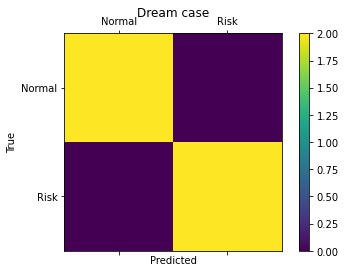

In [124]:
#Dream case
a = [0,0,1,1]
b = [0,0,1,1]

cm_3 = con_mat_picture(a, b, 'Dream case')